## Portfolio Optimization Using Qiskit 1.0.2

For a slightly more in depth look at general QUBO set up and execution please look at max_cut.ipynb



# Problem Definition

I am relatively new to financial applications so for the purpose of deeper learning I am going to be overly specific and try to outline the entire process starting from step 0.

### What is Portfolio Optimization

The high level idea of this is to *maximize profit* while *minimizing risk* the general ideas and terms we will use are:

1. **Asset:**	A stock, bond, or financial product you can invest in
2. **Return:** ($r_i$) The expected return (% gain) of asset 
3. **Variance:** ($\sigma_{i}^{2}$) risk/volatility of asset i
4. **Covariance:** ($\sigma_{ij}$) correlation between two assets
5. **Portfolio:** A set of assets that have been chosen to invest in

## Breaking down the formula

#### The formula from the qiskit tutorials:

$
\min_{x \in \{0,1\}^n} \quad q \cdot x^T \Sigma x - \mu^T x \\
\text{subject to: } \mathbf{1}^T x = B
$

#### Equivalent maximization form

$
\max_{x \in \{0,1\}^n} \quad \mu^T x - \gamma \cdot x^T \Sigma x \\
\text{subject to: } \sum_{i=1}^n x_i = B
$

These two are equivalent, for the purposes of this we will stick to minimizing as finding the ground state (minimum) is the natural way to do this

Now what do these terms mean:
$-\mu^T x$ : the negative of the expected return multiplied by the binary value of whether you choose that asset or not
$\quad q \cdot x^T \Sigma x$ : this is essentially just the risk, or penalty for choosing a COMBINATION of assets (quadratic penalty)

1. q is "risk appetite" lower means less risk averse, higher means we are more risk averse
2. The sum part handles risk across the chosen assets

# Problem Formulation

I am following the tutorial pretty close here  (https://qiskit-community.github.io/qiskit-optimization/tutorials/08_cvar_optimization.html) but let's breakdown what we are plugging into our equation:

1. n = 6            -- manageable problem size for number of assets we are looking at, real world scenarios would be larger
2. q = 0.5          -- Middleground risk weight, reward and risk are considered fairly evenly can be adjusted in real world based on results
3. budget = n // 2  -- choose half of the stocks, this is again a middleground answer where we want to be moderately selective
4. penalty = 2 * n  -- scaling of penalty term, this is objectively a simplification but gives us a reasonable penalty for violating the constraint without skewing objective

our mu and sigma are pulled from: https://quantum-journal.org/papers/q-2020-04-20-256/pdf/
meant to resemble realistic values: for real data you can pull your own or use: (mu, sigma = portfolio.random_model(n, seed=123)) for random data

The tutorial also uses docplex for this, but in the spirit of staying qiskit native I will be avoiding it.

In [8]:
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_optimization import QuadraticProgram
from qiskit.primitives import Sampler, Estimator

import numpy as np
import matplotlib.pyplot as plt

algorithm_globals.random_seed = 123456

# prepare problem instance
n = 6  
q = 0.5  
budget = n // 2  
penalty = 2 * n 

mu = np.array([0.7313, 0.9893, 0.2725, 0.8750, 0.7667, 0.3622])
sigma = np.array(
    [
        [0.7312, -0.6233, 0.4689, -0.5452, -0.0082, -0.3809],
        [-0.6233, 2.4732, -0.7538, 2.4659, -0.0733, 0.8945],
        [0.4689, -0.7538, 1.1543, -1.4095, 0.0007, -0.4301],
        [-0.5452, 2.4659, -1.4095, 3.5067, 0.2012, 1.0922],
        [-0.0082, -0.0733, 0.0007, 0.2012, 0.6231, 0.1509],
        [-0.3809, 0.8945, -0.4301, 1.0922, 0.1509, 0.8992],
    ]
)

## Initialize Quadratic Variables
qp = QuadraticProgram("portfolio_opt")

# 1. Add binary decision variables
for i in range(n):
    qp.binary_var(name=f"x{i}")

# 2. Add the budget constraint: sum(x) == budget
qp.linear_constraint(
    linear={f"x{i}": 1 for i in range(n)},
    sense="==",
    rhs=budget,
    name="budget_constraint"
)

# 3. Add the quadratic objective: q * x^T Σ x - μ^T x
linear = {f"x{i}": -mu[i] for i in range(n)}
quadratic = {
    (f"x{i}", f"x{j}"): q * sigma[i, j]
    for i in range(n) for j in range(n)
}

qp.minimize(linear=linear, quadratic=quadratic)
print(qp.prettyprint())

Problem name: portfolio_opt

Minimize
  0.3656*x0^2 - 0.6233*x0*x1 + 0.4689*x0*x2 - 0.5452*x0*x3 - 0.0082*x0*x4
  - 0.3809*x0*x5 + 1.2366*x1^2 - 0.7538*x1*x2 + 2.4659*x1*x3 - 0.0733*x1*x4
  + 0.8945*x1*x5 + 0.57715*x2^2 - 1.4095*x2*x3 + 0.0007*x2*x4 - 0.4301*x2*x5
  + 1.75335*x3^2 + 0.2012*x3*x4 + 1.0922*x3*x5 + 0.31155*x4^2 + 0.1509*x4*x5
  + 0.4496*x5^2 - 0.7313*x0 - 0.9893*x1 - 0.2725*x2 - 0.875*x3 - 0.7667*x4
  - 0.3622*x5

Subject to
  Linear constraints (1)
    x0 + x1 + x2 + x3 + x4 + x5 == 3  'budget_constraint'

  Binary variables (6)
    x0 x1 x2 x3 x4 x5



# Solving 

We follow the same general idea that we followed in max-cut:

1. get quadratic program
2. choose ansatz
3. choose classical optimizer
4. choose variational solver
5. plug and play

I am still not 100% clear on which one to choose for each spot one as there seem to be a lot of options but our current choices are rooted in simplicity

1. RealAmplitudes hardware efficient, and parameter efficient. It is generalizeable and non problem specific. This makes it flexible for general use, but potentially inefficient when the cost Hamiltonian has exploitable structure (as in Ising-type or constraint-heavy QUBOs).

2. COBYLA (Constrained optimization by linear approximation) again solid for small problems, is not global so can "get stuck" in local minima, works will with shallow ansatz and small parameter counts. Since it's gradient-free, it's especially suited for quantum objectives, which are often noisy, non-differentiable, or expensive to evaluate.

3. While solver selection is outside the scope of this notebook, we refer to arXiv:2408.03613 which uses a supervised learning approach to empirically determine which solver performs best on various QUBO problems. Their results suggest that VQE performs best on portfolio optimization, supporting its use here.




State, Probability
('101100', 0.9375)


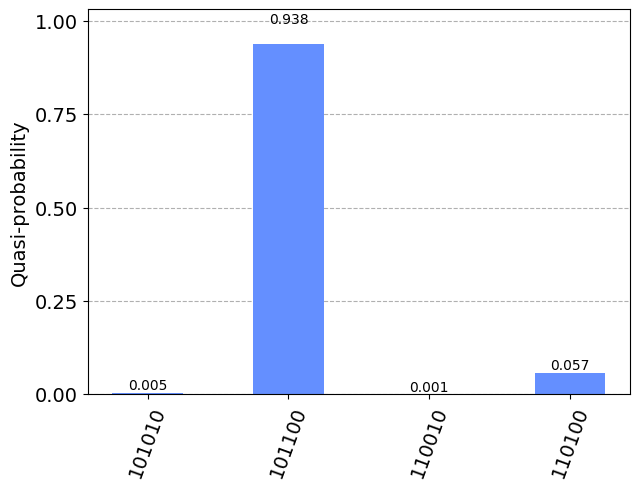

In [ ]:
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.visualization import plot_histogram

max_iter = 100

conv = QuadraticProgramToQubo()
unconstrained_qp = conv.convert(qp) ### HERE WE HAVE CONSTRAINTS SO WE HAVE TO CONVERT CONSTRAINT INTO PENALTY
hamiltonian, offset = unconstrained_qp.to_ising()
ansatz = RealAmplitudes(num_qubits=n, reps=1)
estimator = Estimator()
optimizer = COBYLA(maxiter=max_iter)

vqe = VQE(estimator, ansatz, optimizer)

result = vqe.compute_minimum_eigenvalue(hamiltonian)
optimal_state = ansatz.assign_parameters(result.optimal_parameters)
optimal_state.measure_all()

sampler = Sampler(options={"shots": 1024})
distribution = sampler.run([optimal_state]).result().quasi_dists[0]

solution = max(distribution.binary_probabilities().items(), key=lambda x: x[1])
print("State, Probability")
print(solution)
plot_histogram(distribution.binary_probabilities())

## Final Notes

This is a basic and functional implementation of portfolio optimization formulated as a QUBO problem and solved using a variational quantum algorithm. It follows a clean, modular structure: define the quadratic program, map it to an Ising Hamiltonian, select an ansatz, a classical optimizer, and apply a variational solver (VQE). This approach is well-suited for small-scale or educational problems and provides transparency into each step of the process.

The [Qiskit tutorial](https://qiskit-community.github.io/qiskit-optimization/tutorials/08_cvar_optimization.html), on which this is loosely based, introduces several advanced features that improve performance on more complex or noisy problems. These include:

- **CVaR (Conditional Value at Risk)**: A risk-sensitive optimization strategy that focuses on minimizing the expectation over the best α-percent of outcomes rather than the full distribution. This can lead to more stable convergence and better performance in noisy or multimodal landscapes.
- **SamplingVQE**: A variant of VQE better suited for use with samplers and CVaR aggregation strategies.
- **Classical benchmarking**: Comparing quantum solutions against those from classical eigensolvers (e.g., NumPyMinimumEigensolver) provides a baseline for evaluation.
- **Callback tracking**: Capturing the objective value over iterations enables insight into convergence behavior and optimization dynamics.

These optimizations are not strictly necessary for solving the problem, but they become increasingly valuable as the size, complexity, or noise in the problem increases. Future extensions might include testing different solvers (e.g., QAOA), exploring CVaR, or evaluating solutions across multiple risk-aversion levels.

This implementation intentionally favors clarity and foundational understanding over abstraction or automation. It can serve as a solid base for more sophisticated quantum finance workflows.
